# Analysis with grain data

Using the previously developed tools and functions, we can compare the results of the analytic solution to that of presolar grain data. In doing so one may want to modify cross sections and initial abundances. This notebook goes through this process and offers insight into how these adjustments change the overall production of certain species in the neutron burst. 

# Preliminaries 
We begin by importing the necessary libraries:

In [70]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy', 'wnutils', 'wnnet', 'matplotlib', 'ipywidgets', 'wnpoly'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
import wnutils.xml as wx
import wnpoly as wp
import matplotlib.pyplot as plt
from statistics import geometric_mean
import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
import math
from IPython.display import display, Math

Now, we define the same functions as in the previous notebook:

In [71]:
def get_sigs(net, t9):
    induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
    reacs = net.compute_rates(t9, reac_xpath = induced_reac_xpath)
    rates = []
    for key, values in list(reacs.items()):
        rates.append(values[0])
    
    ordered_dict = {}

    for sp in species:
        for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
            if sp in value.reactants:
                ordered_dict[sp] = reacs[key][0]
            
    T = t9 * 10**9
    k = wn.consts.consts.GSL_CONST_CGS_BOLTZMANN
    N_A = wn.consts.consts.GSL_CONST_NUM_AVOGADRO
    m_n = wn.consts.consts.GSL_CONST_CGS_MASS_NEUTRON
    v_T = np.sqrt((2*k*T)/m_n)
    sigs_array = []
    for key, value in ordered_dict.items():
        sigs_array.append(1000*value/(v_T*N_A*wn.consts.consts.GSL_CONST_CGSM_BARN))
        
    return sigs_array

In [72]:
def get_abunds(solar_xml, my_species):
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    a = []
    d = {}

    for isotope in my_species:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        if s_tup in x_solar:
            a.append(s_tup[2])
            d[s_tup[0]] = x_solar[s_tup] / tup[1]
        else:
            a.append(s_tup[2])
            d[s_tup[0]] = 0
            
    return a, d

In [73]:
def get_variables(sigs_array, j):
    s = wp.symm.Complete()
    h = s.compute_normalized(sigs_array, j) 
    b = wp.bell.Bell()
    x = b.invert(h)
    if len(sigs_array)>1:
        gmean = geometric_mean(sigs_array[0:len(sigs_array)-1])
    else:
        gmean = 1
    return [len(sigs_array), gmean, x]

In [74]:
def g_numerical(t, y, sigmas):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigmas[0]*y[0]
    for i in range(1, N):
        result[i] = sigmas[i-1]*y[i-1] - sigmas[i]*y[i]
    return result

def g_analytic(tau, tup):
    result = 0
    for n in range(len(tup[2])):
        result += tup[2][n] * np.power(-tau, n) / math.factorial(n)
    return np.power(tup[1] * tau, tup[0]-1) * np.exp(result) / math.factorial(tup[0]-1)

In [186]:
def compute_matrix(my_sig_array,  my_species):
    matrix = np.empty((len(my_species),len(my_species)), dtype = "object")

    for i in range(len(my_species)):
        for j in range(len(my_species)):
            if j<=i: 
                sigmas = my_sig_array[j:i+1]
                matrix[i,j] = get_variables(sigmas, 4)
            else:
                matrix[i,j] = 0
                
    return matrix

In [187]:
def compute_gs(my_sig_array, taus, my_species):
    matrix = compute_matrix(my_sig_array, my_species)
    
    Gs = np.empty((len(my_species),len(my_species)), dtype = "object")
    
    for i in range(len(my_species)):
        for j in range(len(my_species)):
            if j<=i:
                Gs[i,j] = g_analytic(taus, matrix[i,j])
            else:
                Gs[i,j] = 0
                
    return Gs

And finally we import the network xml file and the solar abundances from Lodders:

In [188]:
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
#net = wn.net.Net("example_net.xml")

In [189]:
solar_xml = wx.Xml(io.BytesIO(requests.get("https://osf.io/j67qa/download").content))
#solar_xml = wx.Xml("example_solar.xml")

## Define your network

First, we define the isotope chain that we are interested in exploring the effects of the neutron burst on:

In [190]:
species = ['ni58','ni59','ni60','ni61','ni62','ni63','ni64']

Now, since the neutron burst happens at roughly the same temperature, we can define a single temperature and assume the neutron capture cross sections do not vary significantly over the course of the burst:

In [191]:
t9 = 0.7

sigs_array = get_sigs(net, t9)

for i in range(len(sigs_array)):
    latex_name = solar_xml.get_latex_names([species[i]])[species[i]]
    sig_value = sigs_array[i]

    latex_str = f"$\sigma_n$({latex_name}) : {sig_value:.4f} $\, \\text{{mb}}$"

    display(Math(latex_str))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Compute abundances 
Following the procedure outlined in the previous notebook we can compute the abundances for this network in the neutron burst. First we get the initial abundances of the species taken here as solar via Lodders:

In [192]:
a, y0 = get_abunds(solar_xml, species)
y0_list = []
for sp in species:
    y0_list.append(y0[sp])
y0_array = np.array(y0_list)

Now, we compute the abundances after an exposure of $\tau$. Here $\tau=0.1$ which appears to be on the low end of exposures in the neutron burst as suggested from supernova multi zone network calculations. For explosion energies greater than 1.2e51 the exposures can get much higher. 

In [216]:
tau = .1
Gs = compute_gs(sigs_array, tau, species)
abundances = np.dot(Gs, y0_array)

## Analysis 
Now we can begin our analysis against presolar grain data. First we define a grain data dictionary which includes the mass numbers of the species for plotting, the data, and its error. Here the data is presented as Ratios/Solar or:
\begin{gather}
\frac{\delta}{1000}+1
\end{gather}

In [217]:
grains = [
    {'name' : 'grain data',
      'a': [60, 61, 62, 63, 64],
      'data': [1.44, 9.25, 9.02, 6.58, 22.27],
      'error': [.07, .81, .5, .36, 1.29] 
    }
]

for g in grains:
    assert len(g['a']) == len(g['data']) == len(g['error'])

To convert our analytic results to the same format as the grain data we select the normalizing species used when measuring the $\delta$ values and convert the analytic results:

In [228]:
normalizing_species = 'ni58'
factor = y0[normalizing_species]/abundances[species.index(normalizing_species)]
vals = []
ayes = []
for sp in species:
    if y0[sp] != 0:
        vals.append(abundances[species.index(sp)]/y0[sp] * factor)
        ayes.append(a[species.index(sp)])

## Changing $\sigma$

Now to analyze how changing the neutron capture cross sections can modify the result one can define a sigma weight array to modify the relevant neutron capture rates. You will have to modify this dictionary to accomodate changes to the network defined at the beginning of the notebook. Here we change the $\sigma_n$($^{61}$Ni to half of its original value and the $\sigma_n$($^{63}$Ni to 3x it's original value:

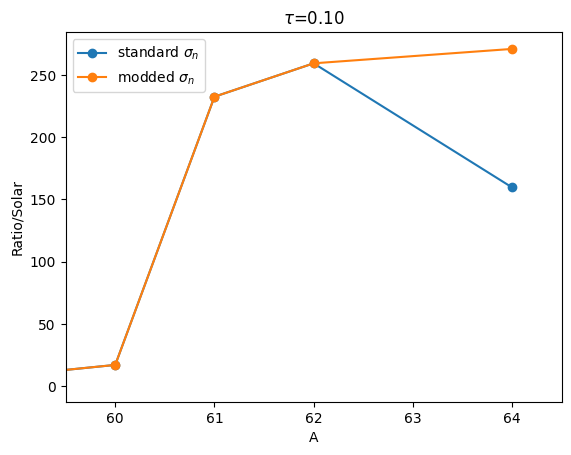

In [231]:
sigs_weight = [1, 1, 1, 1, 1, 3, 1]
sigs_mod = []
for i in range(len(sigs_weight)):
    sigs_mod.append(sigs_array[i]*sigs_weight[i])


tau = .1
tau_mod = .1
Gs = compute_gs(sigs_array, tau, species)
abundances = np.dot(Gs, y0_array)

Gs_mod = compute_gs(sigs_mod, tau_mod, species)
abundances_mod = np.dot(Gs_mod, y0_array)
vals_mod = []
for sp in species:
    if y0[sp] != 0:
        vals_mod.append(abundances_mod[species.index(sp)]/y0[sp] * factor)
    

plt.plot(ayes, vals, '-o', label = r'standard $\sigma_n$')
plt.plot(ayes, vals_mod, '-o', label = fr'modded $\sigma_n$')
#plt.errorbar(grains[0]['a'], grains[0]['data'], yerr = grains[0]['error'], label = 'Grain Data')
plt.title(fr'$\tau$={tau:.2f}')
plt.xlabel('A')
plt.ylabel('Ratio/Solar')
plt.legend()
plt.xlim([59.5,64.5])
plt.show()

In the next cell we display the resulting neutron capture cross sections:

In [197]:
for i in range(len(sigs_array)):
    latex_name = solar_xml.get_latex_names([species[i]])[species[i]]
    sig_value = sigs_mod[i]

    latex_str = f"$\sigma_n$({latex_name}) : {sig_value:.4f} $\, \\text{{mb}}$"

    display(Math(latex_str))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Changing composition
One can also see the effect of changing the initial composition. Here we define a y0_mods array. The elements of this array will be added to the initial solar abundances:

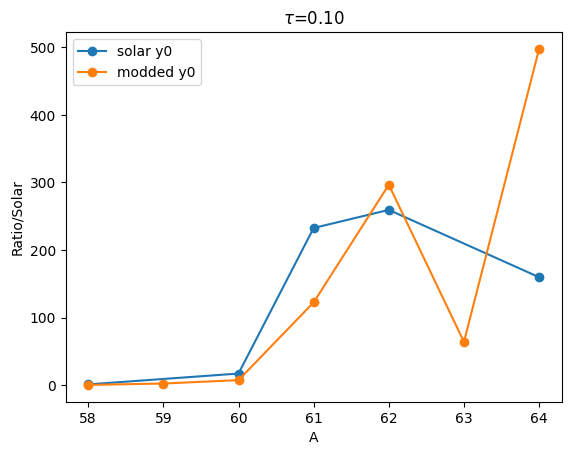

In [198]:
y0_mods = [0, 1e-7, 0, 0, 0, 1e-7, 0]
y0_mod = []
for i in range(len(y0_array)):
    y0_mod.append(y0_array[i]+y0_mods[i])

Gs_mod = compute_gs(sigs_array, tau_mod, species)
abundances_mod = np.dot(Gs_mod, y0_mod)
vals_mod = []
for i in range(len(y0_array)):
    if y0_mod[i] != 0:
        vals_mod.append(abundances_mod[i]/y0_mod[i] * factor)
        
        
plt.plot(ayes, vals, '-o', label = r'solar y0')
plt.plot(a, vals_mod, '-o', label = fr'modded y0')
#plt.errorbar(grains[0]['a'], grains[0]['data'], yerr = grains[0]['error'], label = 'Grain Data')
plt.title(fr'$\tau$={tau:.2f}')
plt.xlabel('A')
plt.ylabel('Ratio/Solar')
plt.legend()
plt.show()

## Modifying both composition and $\sigma$

In [147]:
sigs_weight = [1, 1, 1, .5, 1, 3, .5]
sigs_mod = []
for i in range(len(sigs_weight)):
    sigs_mod.append(sigs_array[i]*sigs_weight[i])
    
y0_mods = [0, 1e-7, 0, 0, 0, 1e-7, 0]
y0_mod = []
for i in range(len(y0_array)):
    y0_mod.append(y0_array[i]+y0_mods[i])
    


array([4.240624366221268e-08, 4.758305825028319e-08,
       3.027899972117414e-07, 1.7697672648984296e-07,
       6.47979890787976e-07, 2.0074087775684592e-07,
       1.5614640200350182e-07], dtype=object)